# Re-Identification using TAO ReIdentificationNet

Transfer learning is the process of transferring learned features from one application to another. It is a commonly used training technique where you use a model trained on one task and re-train to use it on a different task. 

Train Adapt Optimize (TAO) Toolkit  is a simple and easy-to-use Python based AI toolkit for taking purpose-built AI models and customizing them with users' own data.

<img align="center" src="https://d29g4g2dyqv443.cloudfront.net/sites/default/files/akamai/TAO/tlt-tao-toolkit-bring-your-own-model-diagram.png" width="1080">


## Learning Objectives

In this notebook, you will learn how to leverage the simplicity and convenience of TAO to:

* Train a model for re-identification on the [Market-1501](https://zheng-lab.cecs.anu.edu.au/Project/project_reid.html) dataset.
* Evaluate the trained model & visualize results.
* Run Inference on the trained model.
* Export the trained model to an ONNX file for deployment to DeepStream or TensorRT.

At the end of this notebook, you will have generated a trained and optimized `reidentification` model, 
which you may deploy with this [end-to-end sample](https://github.com/NVIDIA-AI-IOT/tao-toolkit-triton-apps) with Triton.

## Table of Contents

This notebook shows an example usecase of ReIdentificationNet using Train Adapt Optimize (TAO) Toolkit.

0. [Set up env variables and map drives](#head-0)
1. [Installing the TAO launcher](#head-1)
2. [Prepare dataset and pre-trained model](#head-2)
3. [Provide training specification](#head-3)
4. [Run TAO training](#head-4)
5. [Evaluate trained models](#head-5)
6. [Inferences](#head-6)
7. [Deploy](#head-7)


## 0. Set up env variables and map drives <a class="anchor" id="head-0"></a>

When using the purpose-built pretrained models from NGC, please make sure to set the `$KEY` environment variable to the key as mentioned in the model overview. Failing to do so, can lead to errors when trying to load them as pretrained models.

The TAO launcher uses docker containers under the hood, and **for our data and results directory to be visible to the docker, they need to be mapped**. The launcher can be configured using the config file `~/.tao_mounts.json`. Apart from the mounts, you can also configure additional options like the Environment Variables and amount of Shared Memory available to the TAO launcher. <br>

`IMPORTANT NOTE:` The code below creates a sample `~/.tao_mounts.json`  file. Here, we can map directories in which we save the data, specs, results and cache. You should configure it for your specific case so these directories are correctly visible to the docker container.


In [8]:
import os

# Please define this local project directory that needs to be mapped to the TAO docker session.
%env LOCAL_PROJECT_DIR=/home/minigo/Desktop/TAO_toolkit/getting_started_v5.2.0/Pilar_11cam_ReID_116

os.environ["HOST_DATA_DIR"] = os.path.join(os.getenv("LOCAL_PROJECT_DIR", os.getcwd()), "data", "reidentificationnet")
os.environ["HOST_RESULTS_DIR"] = os.path.join(os.getenv("LOCAL_PROJECT_DIR", os.getcwd()), "reidentificationnet")
os.environ["HOST_MODEL_DIR"] = os.path.join(os.getenv("LOCAL_PROJECT_DIR", os.getcwd()), "data", "reidentificationnet", "model")

# Set this path if you don't run the notebook from the samples directory.
# %env NOTEBOOK_ROOT=/path/to/local/tao-experiments/re_identification_net
# The sample spec files are present in the same path as the downloaded samples.
os.environ["HOST_SPECS_DIR"] = os.path.join(
    os.getenv("NOTEBOOK_ROOT", os.getcwd()),
    "specs"
)

# Set your encryption key, and use the same key for all commands
%env KEY = nvidia_tao

env: LOCAL_PROJECT_DIR=/home/minigo/Desktop/TAO_toolkit/getting_started_v5.2.0/Pilar_11cam_ReID_116
env: KEY=nvidia_tao


In [63]:
! mkdir -p $HOST_DATA_DIR
! mkdir -p $HOST_SPECS_DIR
! mkdir -p $HOST_RESULTS_DIR
! mkdir -p $HOST_MODEL_DIR

In [9]:
# Mapping up the local directories to the TAO docker.
import json
import os
mounts_file = os.path.expanduser("~/.tao_mounts.json")
print(mounts_file)

tlt_configs = {
   "Mounts":[
       # Mapping the data directory
       {
           "source": os.environ["LOCAL_PROJECT_DIR"],
           "destination": "/workspace/tao-experiments"
       },
       {
           "source": os.environ["HOST_DATA_DIR"],
           "destination": "/data"
       },
       {
           "source": os.environ["HOST_MODEL_DIR"],
           "destination": "/model"
       },
       {
           "source": os.environ["HOST_SPECS_DIR"],
           "destination": "/specs"
       },
       {
           "source": os.environ["HOST_RESULTS_DIR"],
           "destination": "/results"
       }
   ],
   "DockerOptions": {
        "shm_size": "16G",
        "ulimits": {
            "memlock": -1,
            "stack": 67108864
         }
   }
}
# Writing the mounts file.
with open(mounts_file, "w") as mfile:
    json.dump(tlt_configs, mfile, indent=4)

/home/minigo/.tao_mounts.json


In [ ]:
!cat ~/.tao_mounts.json

## 1. Installing the TAO launcher <a class="anchor" id="head-1"></a>
The TAO launcher is a python package distributed as a python wheel listed in PyPI. You may install the launcher by executing the following cell.

Please note that TAO Toolkit recommends users to run the TAO launcher in a virtual env with python 3.6.9. You may follow the instruction in this [page](https://virtualenvwrapper.readthedocs.io/en/latest/install.html) to set up a python virtual env using the `virtualenv` and `virtualenvwrapper` packages. Once you have setup virtualenvwrapper, please set the version of python to be used in the virtual env by using the `VIRTUALENVWRAPPER_PYTHON` variable. You may do so by running

```sh
export VIRTUALENVWRAPPER_PYTHON=/path/to/bin/python3.x
```
where x >= 6 and <= 8

We recommend performing this step first and then launching the notebook from the virtual environment. In addition to installing TAO python package, please make sure of the following software requirements:
* python >=3.7, <=3.10.x
* docker-ce > 19.03.5
* docker-API 1.40
* nvidia-container-toolkit > 1.3.0-1
* nvidia-container-runtime > 3.4.0-1
* nvidia-docker2 > 2.5.0-1
* nvidia-driver > 455+

Once you have installed the pre-requisites, please log in to the docker registry nvcr.io by following the command below

```sh
docker login nvcr.io
```

You will be triggered to enter a username and password. The username is `$oauthtoken` and the password is the API key generated from `ngc.nvidia.com`. Please follow the instructions in the [NGC setup guide](https://docs.nvidia.com/ngc/ngc-overview/index.html#generating-api-key) to generate your own API key.

Please note that TAO Toolkit recommends users to run the TAO launcher in a virtual env with python >=3.6.9. You may follow the instruction in this [page](https://virtualenvwrapper.readthedocs.io/en/latest/install.html) to set up a python virtual env using the virtualenv and virtualenvwrapper packages.

In [ ]:
# SKIP this step IF you have already installed the TAO launcher.
!pip3 install nvidia-tao

In [5]:
# View the versions of the TAO launcher
!tao info

Configuration of the TAO Toolkit Instance
task_group: ['model', 'dataset', 'deploy']
format_version: 3.0
toolkit_version: 5.2.0
published_date: 12/06/2023


## 2. Prepare dataset and pre-trained model <a class="anchor" id="head-2"></a>
 We will be using the [Market-1501](https://zheng-lab.cecs.anu.edu.au/Project/project_reid.html) dataset for the tutorial. Download the dataset [here](https://drive.google.com/file/d/1TwkgQcIa_EgRjVMPSbyEKtcfljqURrzi/view?usp=sharing) and extract it. 

In [ ]:
# Download the dataset.
#!pip3 install -U gdown
!gdown https://drive.google.com/uc?id=0B8-rUzbwVRk0c054eEozWG9COHM -O $HOST_DATA_DIR/market1501.zip

In [ ]:
# Extract the files
!unzip -u $HOST_DATA_DIR/market1501.zip -d $HOST_DATA_DIR
!rm -rf $HOST_DATA_DIR/market1501
!mv $HOST_DATA_DIR/Market-1501-v15.09.15 $HOST_DATA_DIR/market1501
#!rm $HOST_DATA_DIR/market1501.zip

In [5]:
# Verify
#!ls -l $HOST_DATA_DIR/market1501
!ls -l $HOST_DATA_DIR/Pilar_11cam_ReID

total 1460
drwxrwxr-x 2 minigo minigo   24576 may  2 14:52 sample_query
drwxrwxr-x 2 minigo minigo  192512 may  2 14:52 sample_test
drwxrwxr-x 2 minigo minigo  221184 may  2 14:52 sample_train
drwxrwxr-x 2 minigo minigo 1044480 may  2 14:56 sample_train_aug


In [ ]:
# import os
# import glob
# import re
# import random

# def sample_dataset(input_dir, output_dir, n_samples, use_ids = None):
#     """Select a subset of images fom input_dir and move them to output_dir.
    
#     Args:
#         input_dir (str): Input Folder Path of the train images.
#         output_dir (str): Output Folder Path of the test images.
#         n_samples (int): Number of samples to use.
#         use_ids(list int): List of IDs to grab from test and query folder.
        
#     Returns:
#         IDs used for sampling
#     """
#     img_paths = glob.glob(os.path.join(input_dir, '*.jpg'))
#     pattern = re.compile(r'([-\d]+)_c(\d)')
#     id_to_img = {}

#     # Grab images with matching ids
#     for img_path in img_paths:
#         pid, _ = map(int, pattern.search(img_path).groups())
#         if pid not in id_to_img:
#             id_to_img[pid] = []
#         id_to_img[pid].append(img_path)
    
#     # Create directory
#     if not os.path.exists(output_dir):
#         os.makedirs(output_dir)
#     else:
#         command = "rm -r " + output_dir
#         os.system(command)
#         os.makedirs(output_dir)

#     assert id_to_img, "Dataset size cannot be 0."

#     sampled_id_to_img = dict(random.sample(id_to_img.items(), n_samples))

#     for key, img_paths in sampled_id_to_img.items():
#         for img_path in img_paths:
#             command = "cp " + img_path + " " + output_dir
#             os.system(command)

#     # Use same ids for test and query
#     if use_ids:    
        
#         # Create query dir
#         if not os.path.exists(output_dir):
#             os.makedirs(output_dir)
#         else:
#             command = "rm -r " + output_dir
#             os.system(command)
#             os.makedirs(output_dir)

#         # Find images in test with same id
#         img_paths = glob.glob(os.path.join(input_dir, '*.jpg'))
#         for id in use_ids:
#             pattern = re.compile(r'([-\d]+)_c(\d)')
#             for img_path in img_paths:
#                 pid, _ = map(int, pattern.search(img_path).groups())
#                 if id == pid:
#                     print(img_path)
#                     command = "cp " + img_path + " " + output_dir
#                     os.system(command)

#     return sampled_id_to_img.keys()

# # Number of samples
# n_samples = 702
# data_dir = os.path.join(os.environ["HOST_DATA_DIR"], "DukeMTMC_ReID")

# # Create train dataset
# train_input_dir = os.path.join(data_dir, "bounding_box_train")
# train_output_dir = os.path.join(data_dir, "sample_train")
# sample_dataset(train_input_dir, train_output_dir, n_samples)

# # Create test dataset
# test_input_dir = os.path.join(data_dir, "bounding_box_test")
# test_output_dir = os.path.join(data_dir, "sample_test")
# ids = sample_dataset(test_input_dir, test_output_dir, n_samples)

# # Create query dataset
# query_input_dir = os.path.join(data_dir, "query")
# query_output_dir = os.path.join(data_dir, "sample_query")
# sample_dataset(query_input_dir, query_output_dir, n_samples, ids)

In [ ]:
# We provide pre-trained models for Swin-Tiny & Swin-Base variants.
# Swin-Tiny offers faster training whereas Swin-Base offers higher accuracy.

# For faster training, use the pre-trained Swin-Tiny model.
# Download it using the following command:
!mkdir -p $HOST_MODEL_DIR/market1501
!gdown https://drive.google.com/uc?id=1sPLlpcqluyncqSnps88WfkfbshXyXB7F -O $HOST_MODEL_DIR/market1501/swintiny_pretrained.pth

# For higher accuracy, use the pre-trained Swin-Base model.
# Download it using the following command:
# !gdown https://drive.google.com/uc?id=12R97_bSVLCKsPx1E8zPj0ltK6_MDYGhn -O $HOST_MODEL_DIR/market1501/swinbase_pretrained.pth

## 3. Provide training specification <a class="anchor" id="head-3"></a>

We provide specification files to configure the training parameters including:

* model: configure the model setting
  * backbone: type of backbone architecture, example: swin_tiny_patch4_window7_224, swin_base_patch4_window7_224
  * last_stride: stride size
  * pretrain_choice: type of pretrain choice, self
  * pretrained_model_path: path for the input model
  * input_channels: number of input channels
  * input_width: width of an input image
  * input_height: height of an input image
  * neck: type of neck, bnneck
  * stride_size: size of the stride
  * feat_dim: size of the output embedding
  * no_margin: with soft triplet loss
  * neck_feat: statergy to place neck, after/before
  * metric_loss_type: loss type for model, triplet/center/triplet_center
  * with_center_loss: enabling center loss feature, True/False
  * with_flip_feature: enabling image flipping feature, True/False
  * label_smooth: enabling label smoothing feature, True/False
  * pretrain_hw_ratio: height-width ratio of pre-trained model
* dataset: configure the dataset and augmentation methods
  * train_dataset_dir: path for the train dataset directory
  * test_dataset_dir: path for the test dataset directory
  * query_dataset_dir: path for the query dataset directory
  * num_classes: number of classes
  * batch_size: number of images in 1 batch for training
  * val_batch_size: number of images in 1 batch for validation
  * num_workers: number of workers to do data loading
  * pixel_mean: pixel mean in 3 channels for normalization
  * pixel_std: pixel standard deviation in 3 channels for normalization
  * padding: add padding to images
  * prob: probability of randomly flipping images horizontally
  * re_prob: constant for random erasing
  * sampler: stratergy to load images, softmax_triplet
  * num_instances: number of types 1 images is repeated in a batch
* re_ranking: configure the re-ranking features
  * re_ranking: enabling re-ranking feature, True/False
  * k1: constant for re-reranking feature
  * k2: constant for re-reranking feature
  * lambda_value: constant for re-reranking feature
* train: configure the training hyperparameters
  * optim: configure optimizer
  * num_epochs: number of epochs
  * checkpoint_interval: enabling how often to store models

Please refer to the TAO documentation about ReIdentificationNet to get all the parameters that are configurable.

In [ ]:
!cat $HOST_SPECS_DIR/experiment_market1501_swin.yaml

## 4. Run TAO training <a class="anchor" id="head-4"></a>
* Provide the sample spec file and the output directory location for models.
* WARNING: Training will take several hours or one day to complete.

In [11]:
# NOTE: The following paths are set from the perspective of the TAO Docker.

# The data is saved here
%env DATA_DIR = /data
%env MODEL_DIR = /model
%env SPECS_DIR = /specs
%env RESULTS_DIR = /results

env: DATA_DIR=/data
env: MODEL_DIR=/model
env: SPECS_DIR=/specs
env: RESULTS_DIR=/results


### 4.1 Train Market-1501 model

Set local experiment name and output

In [18]:
exp_path_str="Pilar_11cam_ReID_swin_256x196_aug"
model_name_str=f"{exp_path_str}.tlt"
model_name_str_onnx=f"{exp_path_str}.onnx"

%env exp_path=$exp_path_str
%env model_name=$model_name_str
%env model_name_onnx=$model_name_str_onnx



env: exp_path=Pilar_11cam_ReID_swin_256x196_aug
env: model_name=Pilar_11cam_ReID_swin_256x196_aug.tlt
env: model_name_onnx=Pilar_11cam_ReID_swin_256x196_aug.onnx


We will train a Market-1501 model from scratch.

In [ ]:
print("Train model")
!tao model re_identification train \
                  -e $SPECS_DIR/experiment_market1501_swin.yaml \
                  -r $RESULTS_DIR/$exp_path \
                  -k $KEY

In [ ]:
print('Listing checkpoints:')
print('---------------------')
!ls -ltrh $HOST_RESULTS_DIR/$exp_path/train

In [ ]:
print('Rename a model:')
print('---------------------')
# NOTE: The following command may require `sudo`. You can run the command outside the notebook.
!find $HOST_RESULTS_DIR/market1501/train -name *epoch=* | xargs realpath | xargs -I {} mv {} $HOST_RESULTS_DIR/market1501/train/swintiny_market1501_model.tlt
!ls -ltrh $HOST_RESULTS_DIR/market1501/train/swintiny_market1501_model.tlt

You may use:
`sudo chmod -R 777 Pilar_11cam_ReID`
To remove the protection to remove som archive

## 5. Evaluate trained models <a class="anchor" id="head-5"></a>
Evaluate trained model.

In [ ]:
!tao model re_identification evaluate \
                    -e $SPECS_DIR/experiment_market1501_swin.yaml \
                    -r $RESULTS_DIR/$exp_path \
                    -k $KEY \
                    evaluate.results_dir=$RESULTS_DIR/$exp_path/evaluate \
                    evaluate.checkpoint=$RESULTS_DIR/$exp_path/$model_name \
                    evaluate.output_sampled_matches_plot=$RESULTS_DIR/$exp_path/evaluate/sampled_matches.png \
                    evaluate.output_cmc_curve_plot=$RESULTS_DIR/$exp_path/evaluate/cmc_curve.png \
                    evaluate.test_dataset=$DATA_DIR/Pilar_11cam_ReID/sample_test \
                    evaluate.query_dataset=$DATA_DIR/Pilar_11cam_ReID/sample_query
# $RESULTS_DIR/market1501/train/swintiny_market1501_model.tlt
# $RESULTS_DIR/market1501/train/reid_model_epoch009-v1.tlt

The sampled matches and Cumulative Matching Characteristics (CMC) curve output can be visualized using the following script.

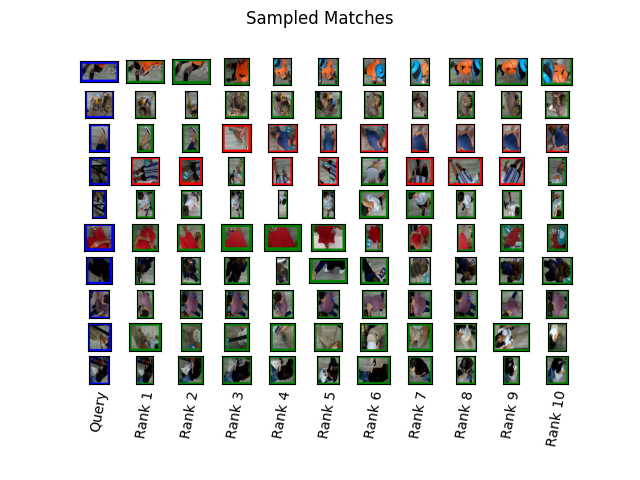

In [21]:
import IPython
from PIL import Image

file_name = os.path.join(os.environ["HOST_RESULTS_DIR"], exp_path_str, "evaluate",  "sampled_matches.png")
IPython.display.display(Image.open(file_name))

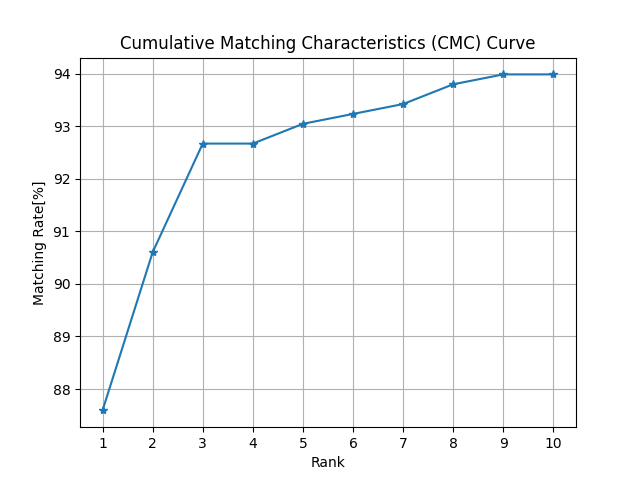

In [20]:
file_name = os.path.join(os.environ["HOST_RESULTS_DIR"], exp_path_str, "evaluate",  "cmc_curve.png")
IPython.display.display(Image.open(file_name))

## 6. Inferences <a class="anchor" id="head-6"></a>
In this section, we run the re-identification inference tool to generate inferences with the trained models and save the results under `$RESULTS_DIR`. 

In [ ]:
!tao model re_identification inference \
                    -e $SPECS_DIR/experiment_market1501_swin.yaml \
                    -r $RESULTS_DIR/$exp_path \
                    -k $KEY \
                    inference.results_dir=$RESULTS_DIR/$exp_path/inference \
                    inference.checkpoint=$RESULTS_DIR/$exp_path/$model_name \
                    inference.output_file=$RESULTS_DIR/$exp_path/inference/inference.json \
                    inference.test_dataset=$DATA_DIR/Pilar_11cam_ReID/sample_test \
                    inference.query_dataset=$DATA_DIR/Pilar_11cam_ReID/sample_query

# inference.checkpoint=$RESULTS_DIR/market1501/train/reid_model_epoch009-v1.tlt \

## 7. Deploy <a class="anchor" id="head-7"></a>
Export the model to an ONNX model.

In [ ]:
!tao model re_identification export \
                   -e $SPECS_DIR/experiment_market1501_swin.yaml \
                   -r $RESULTS_DIR/$exp_path \
                   -k $KEY \
                   export.checkpoint=$RESULTS_DIR/$exp_path/$model_name \
                   export.onnx_file=$RESULTS_DIR/$exp_path/export/$model_name_onnx

# export.checkpoint=$RESULTS_DIR/market1501/train/reid_model_epoch009-v1.tlt \

In [29]:
print('Exported model:')
print('------------')
!ls -lth $HOST_RESULTS_DIR/$exp_path/export

Exported model:
------------
total 108M
-rw-r--r-- 1 root root 108M may  6 09:07 Pilar_11cam_ReID_swin_256x196_aug.onnx


You may continue by deploying the exported model to [Triton Inference Server](https://developer.nvidia.com/nvidia-triton-inference-server). Please refer to the [TAO Toolkit Triton Apps](https://github.com/NVIDIA-AI-IOT/tao-toolkit-triton-apps), where a sample for end-to-end inference is provided. 

# Export the experiment to comet_ml

The test features are normalized.
The distance matrix is processed by re-ranking.
Output CMC curve plot saved at /home/minigo/Desktop/TAO_toolkit/getting_started_v5.2.0/Pilar_11cam_ReID_116/reidentificationnet/Pilar_11cam_ReID_swin_256x196_aug/inference/cmc_curve.png
[87.78195381164551, 90.41353464126587, 92.48120188713074, 92.66917109489441, 93.04511547088623, 93.2330846786499, 93.42105388641357, 93.98496150970459, 93.98496150970459, 93.98496150970459]


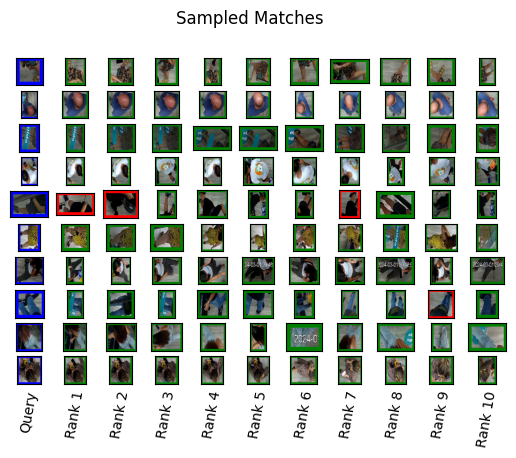

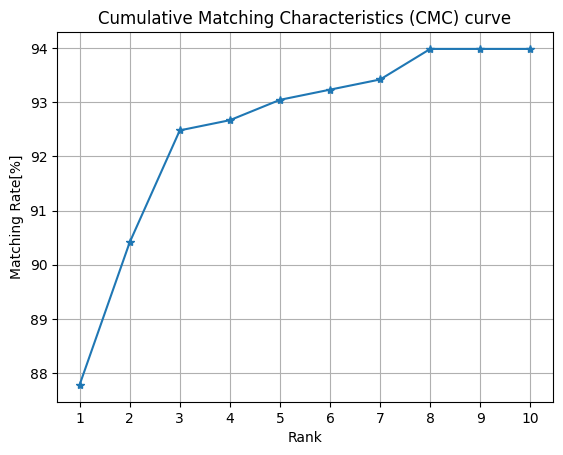

In [19]:
# Plot inference results
import plot_e2e_inference
#json_path="/home/minigo//Desktop/TAO_toolkit/getting_started_v5.2.0/Pilar_11cam_ReID_116/reidentificationnet/Pilar_11cam_ReID_resnet_256x196_v2/inference/inference.json"
json_path=os.path.join(os.environ["HOST_RESULTS_DIR"], os.environ["exp_path"], "inference/inference.json") 
output_path=os.path.join(os.environ["HOST_RESULTS_DIR"], os.environ["exp_path"], "inference")
cmc_percentages=plot_e2e_inference.main(json_path, output_path)
print(cmc_percentages)

In [ ]:
import comet_ml
import json
import yaml
from dotenv import load_dotenv

# Cargar las variables de entorno desde el archivo .env
load_dotenv()

# Cargar COMET_API_KEY 
api_key = os.getenv("COMET_API_KEY")
# Iniciar comet
comet_ml.init(api_key=api_key)
# Establecer nombre del proyecto
exp = comet_ml.Experiment(project_name="Pilar_11cam_ReID_116")
# Establece el nombre del experimento
exp.set_name(exp_path_str)

# Subir hyperparametros desde el yaml de configuracion
yaml_specs_dir = os.path.join(os.environ["HOST_SPECS_DIR"], "experiment_market1501_swin.yaml")
with open(yaml_specs_dir) as f:
  yaml_cfg = f.read()
  config = yaml.safe_load(yaml_cfg)

results_dir = config["results_dir"]
encryption_key = config["encryption_key"]
model_params = config["model"]
dataset_params = config["dataset"]
re_ranking_params=config["re_ranking"]
train_params = config["train"]

exp.log_parameters(model_params)
exp.log_parameters(dataset_params)
exp.log_parameters(re_ranking_params)
exp.log_parameters(train_params)
exp.log_text(text=yaml_cfg)

# Log curvas de entrenamiento
json_train_dir = os.path.join(os.environ["HOST_RESULTS_DIR"], os.environ["exp_path"], "train/status.json")

# Leer el archivo status.json línea por línea y procesar los datos
with open(json_train_dir, "r") as f:
    for line in f:
        # Convertir la línea JSON en un diccionario Python
        status_data = json.loads(line)
        
        # Verificar si el estado es "RUNNING" y contiene métricas
        if status_data.get("status") == "RUNNING" and status_data.get("epoch"):
            # Obtener las métricas del estado
            metrics = status_data["kpi"]
            epoch = status_data["epoch"]
            
            # Registrar todas las métricas en Comet.ml
            exp.log_metrics(metrics, epoch=epoch)

# Registrar la curva CMC como una métrica en CometML

for i, value in enumerate(cmc_percentages):
    exp.log_metrics({"cmc_rank_curve":value}, step=i+1)  
             
# Log las imagenes de evaluacion

exp.log_image(
    image_data=os.path.join(os.environ["HOST_RESULTS_DIR"], os.environ["exp_path"], "evaluate/cmc_curve.png"),
)
exp.log_image(
    image_data=os.path.join(os.environ["HOST_RESULTS_DIR"], os.environ["exp_path"], "evaluate/sampled_matches.png"),
)
# Loguear el modelo .onnx
model_path=os.path.join(os.environ["HOST_RESULTS_DIR"], os.environ["exp_path"], "export", os.environ["model_name_onnx"])
exp.log_model(name="best", file_or_folder=model_path)
exp.end()

In [ ]:
exp.end()